In [28]:
# importing necessary dependancies
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import import_ipynb
import time
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR

In [29]:
# use NVIDIA Geforce GTX 1650
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [30]:
# hyperparameters
batch_size = 64
input_size = 2
hidden_size = 128
num_classes = 1
learning_rate = 0.01
momentum = 0.9
use_nesterov = True
max_norm = 1.0
epochs = 1000

In [31]:
# function to create the adding problem dataset
def adding_problem_generator(N, seq_len=8, high=1):
    """ A data generator for adding problem.

    A single entry has a 2D vector with two rows of the same length. 
    The first row has random numbers, and the second row contains a 
    binary mask with ones at only two positions. The label for this 
    entry is the sum of the numbers from the first row where the mask 
    is one.

     input          label
     -----          -----
    1 4 5 3  ----->   9 (4 + 5)
    0 1 1 0

    N: the number of the entries.
    eq_len: the length of a single sequence.
    p: the probability of 1 in generated mask
    high: the random data is sampled from a [0, high] uniform distribution.
    return: (X, Y), X the data, Y the label.
    """
    X_num = np.random.uniform(low=0, high=high, size=(N, seq_len, 1))
    X_mask = np.zeros((N, seq_len, 1))
    Y = np.ones((N, 1))
    for i in range(N):
        # Default uniform distribution on position sampling
        positions = np.random.choice(seq_len, size=2, replace=False)
        X_mask[i, positions] = 1
        Y[i, 0] = np.sum(X_num[i, positions])
    X = np.append(X_num, X_mask, axis=2)
    return X, Y

In [32]:
# creating the train and test datasets
X_train, Y_train = adding_problem_generator(1000, 10, 1)
X_val, Y_val = adding_problem_generator(100, 10, 1)
X_test, Y_test = adding_problem_generator(100, 10, 1)
X_train = torch.tensor(X_train).float()
Y_train = torch.tensor(Y_train).float()
X_val = torch.tensor(X_val).float()
Y_val = torch.tensor(Y_val).float()
X_test = torch.tensor(X_test).float()
Y_test = torch.tensor(Y_test).float()

In [33]:
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

torch.Size([1000, 10, 2]) torch.Size([1000, 1])
torch.Size([100, 10, 2]) torch.Size([100, 1])
torch.Size([100, 10, 2]) torch.Size([100, 1])


In [34]:
class AddingProblemDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, i):
        return self.X[i], self.Y[i]

train_dataset = AddingProblemDataset(X_train, Y_train)
val_dataset = AddingProblemDataset(X_val, Y_val)

In [35]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

In [44]:
class LSTMNet(nn.Module):

    def __init__(self, input_size: int, hidden_size: int, num_classes: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x_, (h_t, c_t) = self.lstm(x)
        out = F.relu(self.fc(x_[:, -1, :]))
        return out

In [45]:
lstmnet = LSTMNet(input_size, hidden_size, num_classes).to(device)

In [43]:
# total parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

In [39]:
total_lstmnet_parameters = count_parameters(lstmnet)

In [40]:
criterion = nn.MSELoss()
lstmnet_optimizer = torch.optim.SGD(lstmnet.parameters(), lr = learning_rate)
lstmnet_scheduler = torch.optim.lr_scheduler.ExponentialLR(lstmnet_optimizer, gamma=0.95)

In [14]:
lstmnet_train_loss_array = []
lstmnet_val_loss_array = []

In [15]:
# training function
def train_and_validate(num_of_epochs, max_norm, device, model, train_loader, val_loader, loss_function, optimizer, scheduler, train_loss_array, val_loss_array):

    for epoch in range(num_of_epochs):
        model.train(True)
        total_batch_train_loss = 0.0
        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            total_batch_train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            optimizer.step()
        epoch_train_loss = total_batch_train_loss / len(train_loader)

        model.eval()
        total_batch_val_loss = 0.0
        for batch_index, batch in enumerate(val_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            with torch.no_grad():
                output = model(x_batch)
                loss = loss_function(output, y_batch)
                total_batch_val_loss += loss.item()
        epoch_val_loss = total_batch_val_loss / len(val_loader)
        
        train_loss_array.append(epoch_train_loss)
        val_loss_array.append(epoch_val_loss)
        scheduler.step(epoch_val_loss)
        print(f"Epoch no.: {epoch + 1} | Training Loss: {epoch_train_loss} | Validation Loss: {epoch_val_loss}")

In [16]:
lstmnet_start_time = time.time()
train_and_validate(epochs, max_norm, device, lstmnet, train_loader, val_loader, criterion, lstmnet_optimizer, lstmnet_scheduler, lstmnet_train_loss_array, lstmnet_val_loss_array)
lstmnet_end_time = time.time()
lstmnet_total_training_time = lstmnet_end_time - lstmnet_start_time
lstmnet_avg_training_time_per_epoch = lstmnet_total_training_time / epochs

C:\Users\itadmin\Desktop\ComputerScience\btech_project\btp\lib\site-packages\torch\optim\lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch no.: 1 | Training Loss: 0.844403188675642 | Validation Loss: 0.6659364998340607
Epoch no.: 2 | Training Loss: 0.5576371941715479 | Validation Loss: 0.421889528632164
Epoch no.: 3 | Training Loss: 0.3479915801435709 | Validation Loss: 0.25677143037319183
Epoch no.: 4 | Training Loss: 0.22934402897953987 | Validation Loss: 0.18427582830190659
Epoch no.: 5 | Training Loss: 0.18375495821237564 | Validation Loss: 0.16096441447734833
Epoch no.: 6 | Training Loss: 0.17035188805311918 | Validation Loss: 0.1537064090371132
Epoch no.: 7 | Training Loss: 0.16739304922521114 | Validation Loss: 0.15172535181045532
Epoch no.: 8 | Training Loss: 0.16439333790913224 | Validation Loss: 0.1510816365480423
Epoch no.: 9 | Training Loss: 0.16350320167839527 | Validation Loss: 0.1508401408791542
Epoch no.: 10 | Training Loss: 0.1637615249492228 | Validation Loss: 0.15079789608716965
Epoch no.: 11 | Training Loss: 0.16489236522465944 | Validation Loss: 0.1508096531033516
Epoch no.: 12 | Training Loss: 

In [17]:
lstmnet_predictions = lstmnet(X_test.to(device)).cpu().detach().numpy()

In [18]:
print(f"Total Parameters:     LSTMNet: {total_lstmnet_parameters}")

Total Parameters:     LSTMNet: 135425


In [19]:
def plot_loss(epochs, array1, label1, plot_title):
     
    epochs_array = range(1, epochs + 1)
    plt.figure(figsize=(6, 6))
    plt.plot(epochs_array, array1, 'b', label=label1)
    plt.title(plot_title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [20]:
def plot_test_predictions(actual_values, lstm_predicted_values):
    
    epochs = range(1, len(actual_values) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, actual_values, 'g', label='Actual Values')
    plt.plot(epochs, lstm_predicted_values, 'b', label='LSTM Predicted Values')
    plt.title('Test Predictions Comparison')
    plt.xlabel('Samples')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

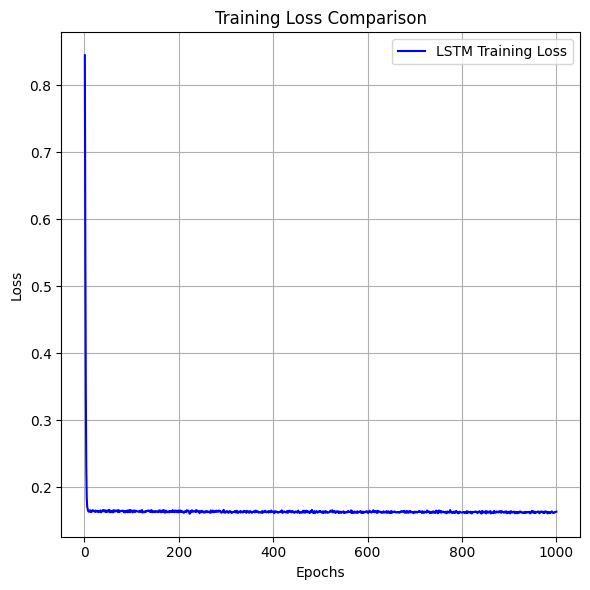

In [21]:
plot_loss(epochs, lstmnet_train_loss_array, "LSTM Training Loss", "Training Loss Comparison")

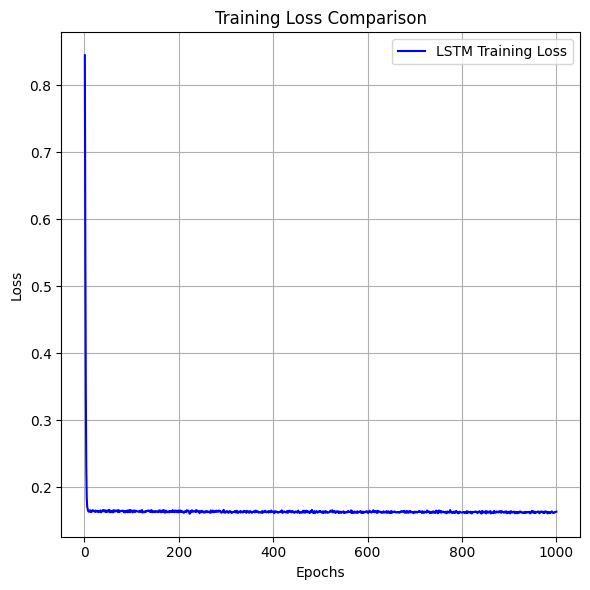

In [22]:
plot_loss(epochs, lstmnet_train_loss_array, "LSTM Training Loss", "Training Loss Comparison")

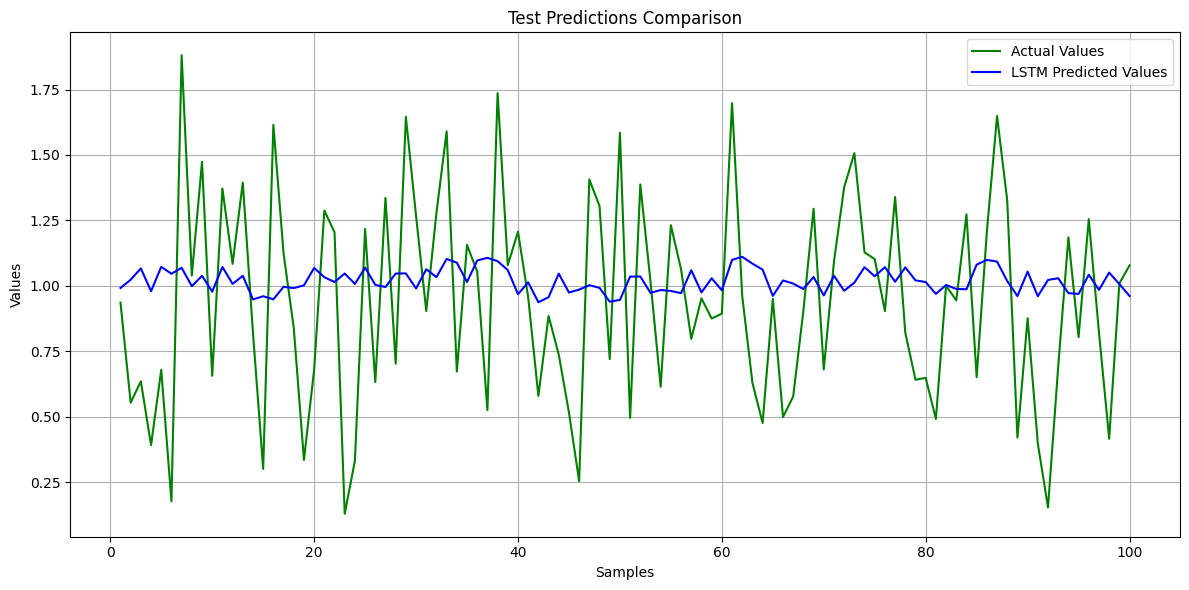

In [23]:
plot_test_predictions(Y_test, lstmnet_predictions)

In [24]:
def compare_mse_loss(actual_values, lstm_predicted_values):
    lstm_mse = mean_squared_error(actual_values, lstm_predicted_values)    
    print(f'LSTM MSE Loss: {lstm_mse}')

In [25]:
compare_mse_loss(Y_test, lstmnet_predictions)

NameError: name 'mean_squared_error' is not defined